In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time
from gprofiler import GProfiler
import gseapy as gp

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [18]:
# Set file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
GS_FILE=DATA_PATH+'/gs_file/magma_10kb_1000.gs'
TRAIT_INFO_FILE=DATA_PATH+'/supp_table/trait_info_full.tsv'
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_hep'

# Data set info
DS_LIST = ['facs', 'xin']
DIC_INFO = {}
DIC_INFO['facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
DIC_INFO['xin'] = {'species': 'hsapiens', 'dname': 'Xin 2018'}
# DIC_INFO['droplet'] = {'species': 'mmusculus', 'dname': 'TMS Droplet'}

# Set score files
DIC_SCORE_PATH = {'facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_1000',
                  'facs.px18': DATA_PATH+'/score_file/score.tms_facs_with_cov.pancreas_xin_2018',
#                   'facs.px18': DATA_PATH+'/score_file/score.tms_facs.pancreas_xin_2018',
                  'xin': DATA_PATH+'/score_file/score.xin_with_cov.magma_10kb_1000',
                  'xin.px18': DATA_PATH+'/score_file/score.xin_with_cov.pancreas_xin_2018',
                 }

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['facs'] = ['PASS_FastingGlucose_Manning',
                          'UKB_460K.biochemistry_Glucose',
                          'UKB_460K.biochemistry_HbA1c',
                          'PASS_Type_2_Diabetes',
                          'PASS_Intelligence_SavageJansen2018',
                          'PASS_VerbalNumericReasoning_Davies2018',
                          'UKB_460K.body_BMIz',
                          'UKB_460K.impedance_BASAL_METABOLIC_RATEz']
DIC_TRAIT_LIST['facs.px18'] = ['UPR', 'Apoptosis', 'Senescence', 'Cell_cycle_G1S', 'Cell_cycle_G2M',
                               'Beta_sub1', 'Beta_sub2', 'Beta_sub3', 'Beta_sub4']
DIC_TRAIT_LIST['xin'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['xin.px18'] = DIC_TRAIT_LIST['facs.px18'].copy()

# Set trait info
DF_TRAIT_INFO = pd.read_csv(TRAIT_INFO_FILE, sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
for trait in DF_TRAIT_INFO.index[DF_TRAIT_INFO['Code'].isna()]:
    trait_short = trait.replace('PASS_','').replace('UKB_460K.','')
    trait_short = trait_short.replace('blood_','').replace('disease_','')
    DF_TRAIT_INFO.loc[trait, 'Code'] = trait_short
    
for trait in DIC_TRAIT_LIST['facs.px18']:
    DF_TRAIT_INFO.loc[trait, ['Trait_Identifier', 'Code']] = [trait, trait]

### Load data 

In [3]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')
# dic_data_raw['droplet'] = dl.load_tms_ct(DATA_PATH, data_name='droplet')
dic_data_raw['xin'] = dl.load_xin_raw_data(opt='raw')

dic_data_proc = {}
dic_data_proc['facs'] = read_h5ad(DATA_PATH+'/single_cell_data/tms_proc/pan_b.facs.h5ad')
dic_data_proc['xin'] = read_h5ad(DATA_PATH+'/single_cell_data/tms_proc/pan_b.xin.h5ad')
# dic_data_proc['facs'] = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='Pancreas')['Pancreas']
# dic_data_proc['droplet'] = dl.load_tms_processed(DATA_PATH, data_name='droplet', tissue='Liver')['Liver']
# dic_data_proc['xin'] = dl.load_xin_raw_data(opt='processed')

# Add mt_prop to facs fata
temp_adata = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/tabula_muris_senis/'
                       'adata_genecode_counts_for_gatk_with_metadata.h5ad')
mt_list = [x for x in temp_adata.var_names if x.startswith('mt-')]
temp_adata.obs['mt_prop'] = temp_adata[:, mt_list].X.sum(axis=1) / temp_adata.X.sum(axis=1)

df_mt = pd.DataFrame(index=dic_data_proc['facs'].obs['cell'])
temp_df = temp_adata.obs.copy()
temp_df.index = temp_df['cell']
df_mt = df_mt.join(temp_df['mt_prop'])
dic_data_proc['facs'].obs['mt_prop'] = df_mt['mt_prop'].values

Trying to set attribute `.obs` of view, copying.
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [4]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.score.gz'%trait)
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

# Cell list to analyze
dic_cell_list = {}
for score in DIC_SCORE_PATH:
    ds = score.split('.')[0]
    dic_cell_list[score] = list(set(dic_data_proc[ds].obs_names) & set(dic_score[score].index))

In [5]:
# Compute correlation between n_gene and score 
dic_data_raw['facs'].obs['n_genes'] = (dic_data_raw['facs'].X>0).sum(axis=1)
df_plot = dic_data_raw['facs'].obs[['n_genes']]
df_plot = df_plot.join(dic_score['facs'])
df_plot = df_plot.loc[df_plot.isna().sum(axis=1)==0]
for trait in DIC_TRAIT_LIST['facs']:
    print('# %-30s    corr=%0.3f'%(trait, np.corrcoef(df_plot['n_genes'], df_plot['%s.norm_score'%trait])[0,1]))

# PASS_FastingGlucose_Manning       corr=-0.019
# UKB_460K.biochemistry_Glucose     corr=-0.014
# UKB_460K.biochemistry_HbA1c       corr=-0.005
# PASS_Type_2_Diabetes              corr=0.002
# PASS_Intelligence_SavageJansen2018    corr=-0.030
# PASS_VerbalNumericReasoning_Davies2018    corr=-0.031
# UKB_460K.body_BMIz                corr=-0.025
# UKB_460K.impedance_BASAL_METABOLIC_RATEz    corr=-0.007


In [7]:
# Load control score 
dic_ctrl_score = {}
for score in DIC_SCORE_PATH:
# for score in ['aizarani.hm']:
    ds = score.split('.')[0]
    dic_ctrl_score[score] = {}
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.full_score.gz'%trait)
        if os.path.exists(file_path):
            print('# Loading %s %s'%(score, trait))
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df = temp_df.loc[set(dic_data_proc[ds].obs_names) & set(temp_df.index)]
            dic_ctrl_score[score][trait] = temp_df.copy()
        else:
            print('# missing: %s'%file_path)
        dic_ctrl_score[score][trait] = dic_ctrl_score[score][trait].loc[dic_cell_list[score]].copy()

# Loading facs PASS_FastingGlucose_Manning
# Loading facs UKB_460K.biochemistry_Glucose
# Loading facs UKB_460K.biochemistry_HbA1c
# Loading facs PASS_Type_2_Diabetes
# Loading facs PASS_Intelligence_SavageJansen2018
# Loading facs PASS_VerbalNumericReasoning_Davies2018
# Loading facs UKB_460K.body_BMIz
# Loading facs UKB_460K.impedance_BASAL_METABOLIC_RATEz
# Loading facs.px18 UPR
# Loading facs.px18 Apoptosis
# Loading facs.px18 Senescence
# Loading facs.px18 Cell_cycle_G1S
# Loading facs.px18 Cell_cycle_G2M
# Loading facs.px18 Beta_sub1
# Loading facs.px18 Beta_sub2
# Loading facs.px18 Beta_sub3
# Loading facs.px18 Beta_sub4
# Loading xin PASS_FastingGlucose_Manning
# Loading xin UKB_460K.biochemistry_Glucose
# Loading xin UKB_460K.biochemistry_HbA1c
# Loading xin PASS_Type_2_Diabetes
# Loading xin PASS_Intelligence_SavageJansen2018
# Loading xin PASS_VerbalNumericReasoning_Davies2018
# Loading xin UKB_460K.body_BMIz
# Loading xin UKB_460K.impedance_BASAL_METABOLIC_RATEz
# Loading x

### UMAP for all hepatocytes

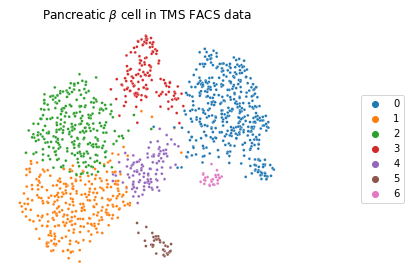

In [70]:
# Figure 
df_plot = pd.DataFrame(index=dic_data_proc['facs'].obs_names,
                       data={'UMAP1':dic_data_proc['facs'].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc['facs'].obsm['X_umap'][:,1]})
df_plot = df_plot.join(dic_data_proc['facs'].obs[['leiden', 'cell_ontology_class']])

plt.figure(figsize=[6,4])
ax = plt.subplot(1,1,1)
ax.axis('off')
g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='leiden', s=8)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('Pancreatic $\\beta$ cell in TMS FACS data')
plt.tight_layout()
# plt.savefig(FIG_PATH+'/hep_tms_annot_umap.svg')
# plt.savefig(FIG_PATH+'/hep_tms_annot_umap.png')
plt.show()

### Subpolulation of associated cells 

PASS_FastingGlucose_Manning


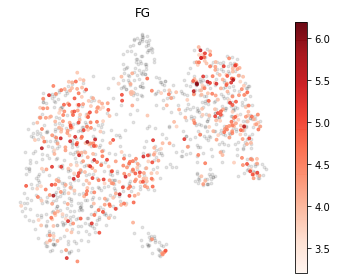

UKB_460K.biochemistry_Glucose


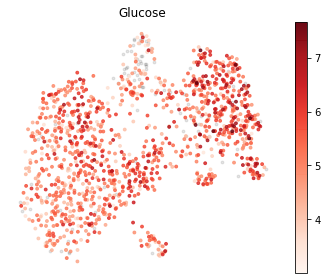

UKB_460K.biochemistry_HbA1c


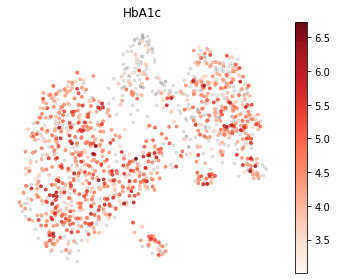

PASS_Type_2_Diabetes


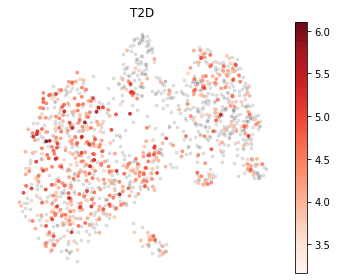

PASS_Intelligence_SavageJansen2018


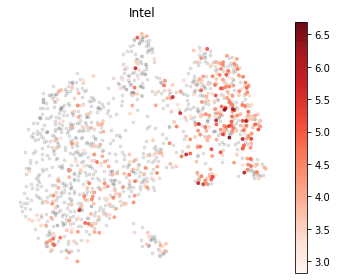

PASS_VerbalNumericReasoning_Davies2018


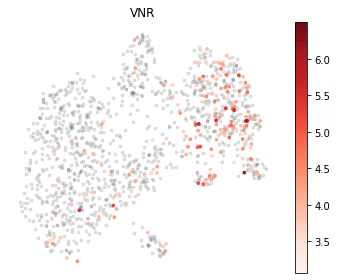

UKB_460K.body_BMIz


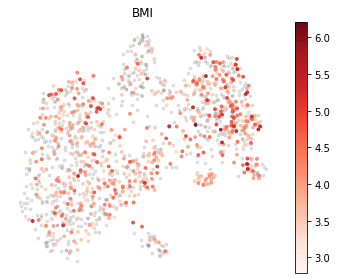

UKB_460K.impedance_BASAL_METABOLIC_RATEz


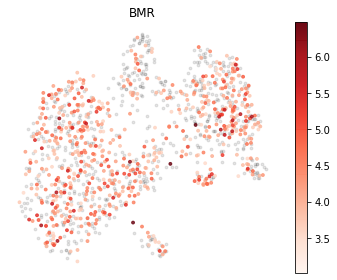

In [14]:
score = 'facs'
ds = score.split('.')[0]
for trait in DIC_TRAIT_LIST[score]:
    print(trait)
    df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                           data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                 'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1], 
                                 'leiden_anno':dic_data_proc[ds].obs['leiden']})
    df_plot = df_plot.join(dic_score[score][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
    df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

    ind_select = df_plot['%s.fdr'%trait]<0.1
#     if ind_select.sum()<10:
#         continue
    
    plt.figure(figsize=[5,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    vmax = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.99) + 0.5
    vmin = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.01) - 0.5
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', s=8, alpha=0.1)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=df_plot.loc[ind_select, '%s.norm_score'%trait],
                cmap='Reds', s=8, vmax=vmax, vmin=vmin, alpha=0.8)
    plt.colorbar()
    plt.title(DF_TRAIT_INFO.loc[trait, 'Code'])

    plt.tight_layout()
#     plt.savefig(FIG_PATH+'/sctrs_assoc.%s.%s.svg'%(ds, trait))
    plt.show()

UPR


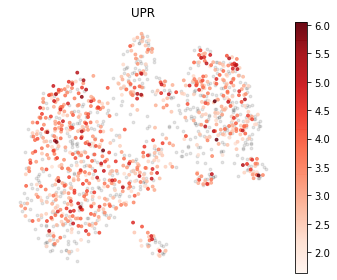

Apoptosis
Senescence
Cell_cycle_G1S
Cell_cycle_G2M
Beta_sub1


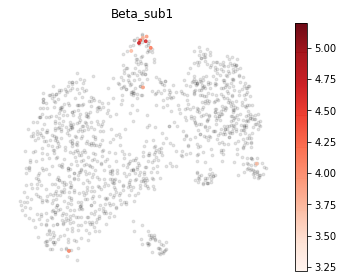

Beta_sub2


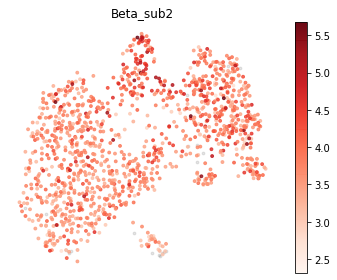

Beta_sub3


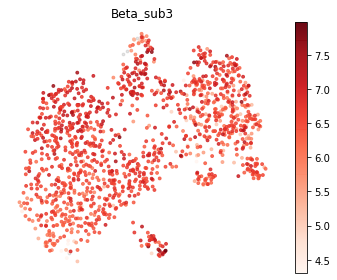

Beta_sub4


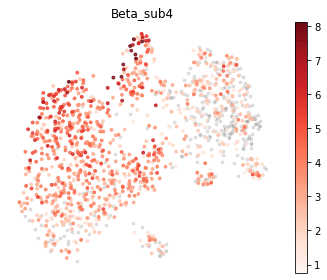

In [31]:
score = 'facs.px18'
ds = score.split('.')[0]
for trait in DIC_TRAIT_LIST[score]:
    print(trait)
    df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                           data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                 'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1], 
                                 'leiden_anno':dic_data_proc[ds].obs['leiden']})
    df_plot = df_plot.join(dic_score[score][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
    df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

    ind_select = df_plot['%s.fdr'%trait]<0.5
    if ind_select.sum()<10:
        continue
    
    plt.figure(figsize=[5,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    vmax = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.99) + 0.5
    vmin = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.01) - 0.5
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', s=8, alpha=0.1)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=df_plot.loc[ind_select, '%s.norm_score'%trait],
                cmap='Reds', s=8, vmax=vmax, vmin=vmin, alpha=0.8)
    plt.colorbar()
    plt.title(DF_TRAIT_INFO.loc[trait, 'Code'])

    plt.tight_layout()
#     plt.savefig(FIG_PATH+'/sctrs_assoc.%s.%s.svg'%(ds, trait))
    plt.show()

PASS_FastingGlucose_Manning


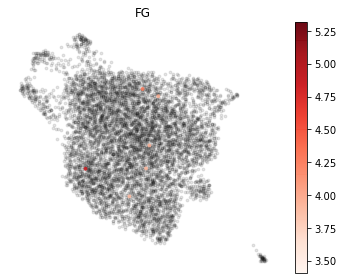

UKB_460K.biochemistry_Glucose


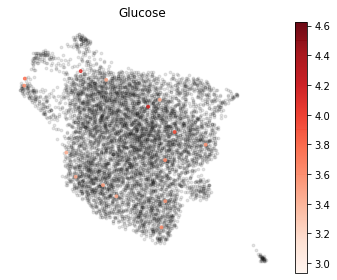

UKB_460K.biochemistry_HbA1c


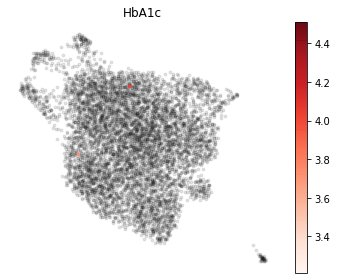

PASS_Type_2_Diabetes
PASS_Intelligence_SavageJansen2018


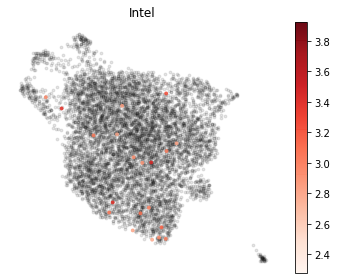

PASS_VerbalNumericReasoning_Davies2018


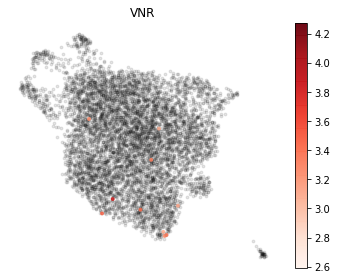

UKB_460K.body_BMIz


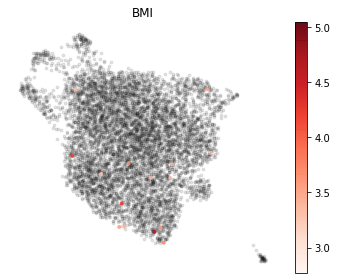

UKB_460K.impedance_BASAL_METABOLIC_RATEz


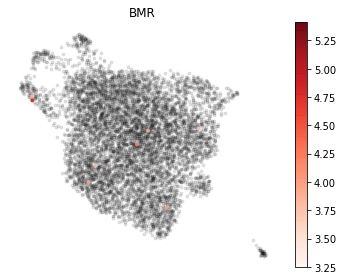

In [91]:
score = 'xin'
ds = score.split('.')[0]
for trait in DIC_TRAIT_LIST[score]:
    print(trait)
    df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                           data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                 'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1], 
                                 'leiden_anno':dic_data_proc[ds].obs['leiden']})
    df_plot = df_plot.join(dic_score[score][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
    df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

    ind_select = df_plot['%s.fdr'%trait]<0.5
#     ind_select = df_plot['%s.nlog10_pval'%trait]>2
    if ind_select.sum()<1:
        continue
    
    plt.figure(figsize=[5,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    vmax = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.99) + 0.5
    vmin = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.01) - 0.5
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', s=8, alpha=0.1)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=df_plot.loc[ind_select, '%s.norm_score'%trait],
                cmap='Reds', s=8, vmax=vmax, vmin=vmin, alpha=0.8)
    plt.colorbar()
    plt.title(DF_TRAIT_INFO.loc[trait, 'Code'])

    plt.tight_layout()
#     plt.savefig(FIG_PATH+'/sctrs_assoc.%s.%s.svg'%(ds, trait))
    plt.show()

In [90]:
ds = 'xin'
for trait in DIC_TRAIT_LIST[ds]:
    score_max = dic_score[ds]['%s.norm_score'%trait].max()
    v_ctrl_score_max = dic_ctrl_score[ds][trait][['ctrl_norm_score_%d'%i for i in range(500)]].max(axis=0)
    print(trait, (v_ctrl_score_max>score_max).mean())

PASS_FastingGlucose_Manning 0.026
UKB_460K.biochemistry_Glucose 0.114
UKB_460K.biochemistry_HbA1c 0.146
PASS_Type_2_Diabetes 0.212
PASS_Intelligence_SavageJansen2018 0.002
PASS_VerbalNumericReasoning_Davies2018 0.008
UKB_460K.body_BMIz 0.058
UKB_460K.impedance_BASAL_METABOLIC_RATEz 0.018


In [29]:
score = 'facs'
temp_df = dic_score[score][['%s.norm_score'%x for x in DIC_TRAIT_LIST[score]]]
temp_df.columns = [DF_TRAIT_INFO.loc[x.replace('.norm_score',''), 'Code'] for x in temp_df.columns]
display(temp_df.corr())

,FG,Glucose,HbA1c,T2D,Intel,VNR,BMI,BMR
FG,1.000000,0.420605,0.323864,0.184711,0.245645,0.244148,0.191316,0.211650
Glucose,0.420605,1.000000,0.472627,0.246262,0.188153,0.186661,0.146813,0.217273
HbA1c,0.323864,0.472627,1.000000,0.209053,0.190941,0.178648,0.152971,0.181380
T2D,0.184711,0.246262,0.209053,1.000000,0.123334,0.105335,0.199270,0.250584
Intel,0.245645,0.188153,0.190941,0.123334,1.000000,0.773972,0.500557,0.395771
VNR,0.244148,0.186661,0.178648,0.105335,0.773972,1.000000,0.418259,0.323423
BMI,0.191316,0.146813,0.152971,0.199270,0.500557,0.418259,1.000000,0.558388
BMR,0.211650,0.217273,0.181380,0.250584,0.395771,0.323423,0.558388,1.000000


In [28]:
score = 'xin'
temp_df = dic_score[score][['%s.norm_score'%x for x in DIC_TRAIT_LIST[score]]]
temp_df.columns = [DF_TRAIT_INFO.loc[x.replace('.norm_score',''), 'Code'] for x in temp_df.columns]
display(temp_df.corr())

,FG,Glucose,HbA1c,T2D,Intel,VNR,BMI,BMR
FG,1.000000,0.293063,0.172749,0.087400,0.037574,0.060593,0.059929,0.072956
Glucose,0.293063,1.000000,0.319859,0.189735,0.067658,0.075599,0.119108,0.160589
HbA1c,0.172749,0.319859,1.000000,0.162073,0.101509,0.095276,0.131506,0.170184
T2D,0.087400,0.189735,0.162073,1.000000,0.038158,0.061174,0.094538,0.082243
Intel,0.037574,0.067658,0.101509,0.038158,1.000000,0.702781,0.283232,0.214065
VNR,0.060593,0.075599,0.095276,0.061174,0.702781,1.000000,0.277201,0.206355
BMI,0.059929,0.119108,0.131506,0.094538,0.283232,0.277201,1.000000,0.372974
BMR,0.072956,0.160589,0.170184,0.082243,0.214065,0.206355,0.372974,1.000000


In [ ]:
DIC_TRAIT_LIST[score]

### Annotation for LDL associated cells 

... storing 'tissue_celltype' as categorical
... storing 'leiden_sig' as categorical


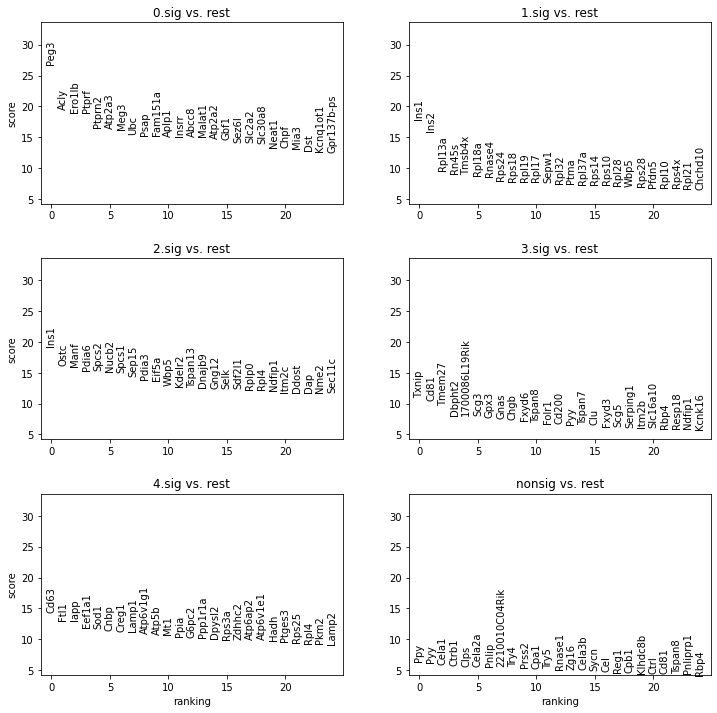

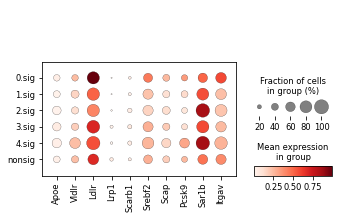

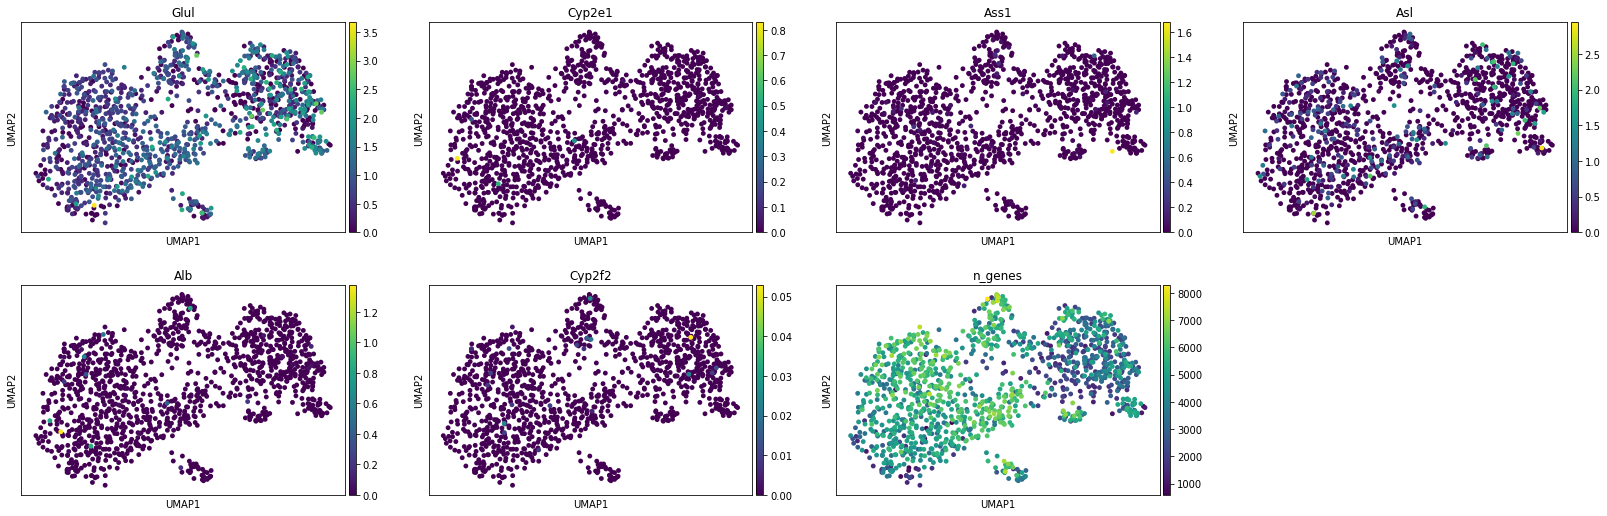

In [93]:
trait = 'UKB_460K.biochemistry_Glucose'
ds = 'facs'

# Assign sig label for each leiden cluster (remove sig cells in small clusters)
# adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata = dic_data_raw[ds][dic_cell_list[ds], :].copy()
temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obs = adata.obs.join(temp_adata.obs[[x for x in temp_adata.obs.columns if x not in adata.obs.columns]])
adata.obsm = temp_adata.obsm

adata.obs = adata.obs.join(dic_score[ds]['%s.fdr'%trait])
adata.obs['leiden_sig'] = ['%s.sig'%x if y<0.1 else 'nonsig'
                           for x,y in zip(adata.obs['leiden'], adata.obs['%s.fdr'%trait])]

temp_df = adata.obs.groupby(['leiden_sig']).agg({'cell':len})
cluster_remove_list = list(temp_df.index[temp_df['cell']<50])
adata.obs.loc[adata.obs['leiden_sig'].isin(cluster_remove_list), 'leiden_sig'] = 'nonsig' 


# Specifically expressed genes 
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
# sc.tl.rank_genes_groups(adata, groupby='leiden_sig', groups=group_list, method='wilcoxon')
sc.tl.rank_genes_groups(adata, groupby='leiden_sig', reference='rest', groups=group_list+['nonsig'])
# adata.obs['leiden_annot'] = [dic_config[x][1] for x in adata.obs['leiden_sig']]
sc.pl.rank_genes_groups(adata, fontsize=10, ncols=2, n_genes=25)

# Marker gene expression 
marker_list = ['Apoe', 
               'Cd81' # CD81 marks immature and dedifferentiated pancreatic β-cells
              ]
for gene in marker_list.copy():
    if gene not in adata.var_names:
        marker_list.remove(gene)
        print('# Removed: %s'%gene)
sc.pl.dotplot(adata, marker_list, groupby='leiden_sig')

# Zonation markers
marker_list = ['Glul', 'Cyp2e1', 'Ass1', 'Asl', 'Alb', 'Cyp2f2', 'n_genes']
sc.pl.umap(adata, color=marker_list)

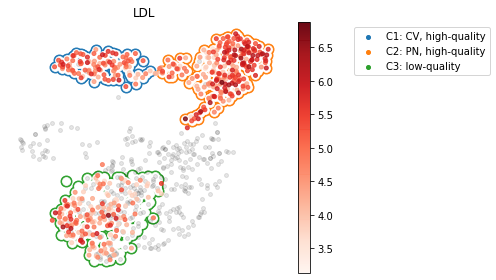

In [27]:
# # UMAP plot with annotations 
# # group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
# group_list = ['4.sig', '2.sig', '0.sig']
# dic_config = {'0.sig': ['C2', 'C3: low-quality'],
#               # Pericentral
#               '2.sig': ['C1', 'C2: PN, high-quality'], 
#               # Periportal 
#               '4.sig': ['C0', 'C1: CV, high-quality'], 
#               # Pericentral 
#               'nonsig': ['k', 'nonsig']
#              }

# # Get df_plot 
# df_plot = pd.DataFrame(index=adata.obs_names,
#                        data={'UMAP1':adata.obsm['X_umap'][:,0],
#                              'UMAP2':adata.obsm['X_umap'][:,1]})
# df_plot = df_plot.join(adata.obs[['leiden', 'leiden_sig']])
# df_plot = df_plot.loc[dic_cell_list[ds]]
# df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
# df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

# # Figure 
# plt.figure(figsize=[7,4])
# ax = plt.subplot(1,1,1)
# ax.axis('off')

# # Cluster boundry 
# x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
# y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
# for cluster in group_list:
#     ind_select = df_plot['leiden']==cluster.split('.')[0]
#     temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
#     xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
#     xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
#     ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
#     ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
#     ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
#                     (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
#     plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
#                 s=16, color=dic_config[cluster][0], 
#                 label=dic_config[cluster][1], zorder=0)
#     plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
#                 s=120, color=dic_config[cluster][0], zorder=1)
#     plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
#                 s=60, color='w', zorder=2)

# ind_select_sig = (df_plot['leiden_sig']!='nonsig')
# np.random.seed(0)
# cell_list_nonsig = np.random.choice(df_plot.index[~ind_select_sig], 
#                                     size=int((~ind_select_sig).sum()*0.5), replace=False)
# plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
#                 c='k', s=16, alpha=0.1, zorder=5)

# vmax = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.99) + 0.5
# vmin = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.01) - 0.5
# plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
#             c=df_plot.loc[ind_select_sig, '%s.norm_score'%trait],
#             cmap='Reds', s=16, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
# plt.colorbar()
# plt.legend(bbox_to_anchor=(1.25, 1), loc='upper left')
# plt.title(DF_TRAIT_INFO.loc[trait, 'Code'])
# plt.tight_layout()
# plt.savefig(FIG_PATH+'/sctrs_assoc.annot_LDL_umap.svg')
# plt.savefig(FIG_PATH+'/sctrs_assoc.annot_LDL_umap.png')
# plt.show()

... storing 'leiden_annot' as categorical


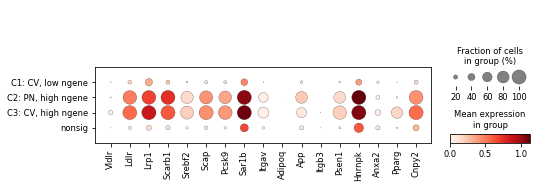

In [14]:
marker_list = ['Vldlr', 'Ldlr', 'Lrp1', 'Scarb1', 'Srebf2', 'Scap', 'Pcsk9', 'Sar1b', 'Itgav', 
               'Adipoq', 'App', 'Itgb3', 'Psen1', 'Hnrnpk', 'Anxa2', 'Pparg', 'Cnpy2'] # Lipoprotein receptor
adata.obs['leiden_annot'] = [dic_config[x][1] for x in adata.obs['leiden_sig']]
sc.pl.dotplot(adata, marker_list, groupby='leiden_annot')

In [97]:
# Pathway: enrichr
dic_pathway = {}
group_list = list(adata.uns['rank_genes_groups']['names'].dtype.names)
pw_list = []
for group in group_list+['nonsig']:
# for group in ['hq', 'lq']:
    df_gene = sc.get.rank_genes_groups_df(adata, group=group)
    gene_list = list(df_gene['names'][:100])

    res = gp.enrichr(gene_list=gene_list, description='pathway',
                         gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2018', 'Reactome_2016'],
                         organism='Mouse', outdir=None)
    df_pathway = res.results
    df_pathway = df_pathway.loc[df_pathway['Adjusted P-value']<0.01].copy()
    df_pathway['Intersect'] = [int(x.split('/')[0]) for x in df_pathway['Overlap']]
    df_pathway['Term_size'] = [int(x.split('/')[1]) for x in df_pathway['Overlap']]
    df_pathway['Recall'] = df_pathway['Intersect'] / df_pathway['Term_size']
    dic_pathway[group] = df_pathway.copy()
    ind_select = (df_pathway['Intersect']>20) | (df_pathway['Recall']>0.20)
    ind_select = ind_select & (df_pathway['Term_size']>10) & (df_pathway['Term_size']<500) 
    pw_list.extend(df_pathway.loc[ind_select, 'Term'])

for group in group_list:
# for group in ['hq', 'lq']:
    dic_pathway[group].index = dic_pathway[group]['Term']
    dic_pathway[group] = dic_pathway[group].loc[set(dic_pathway[group].index) & set(pw_list)]

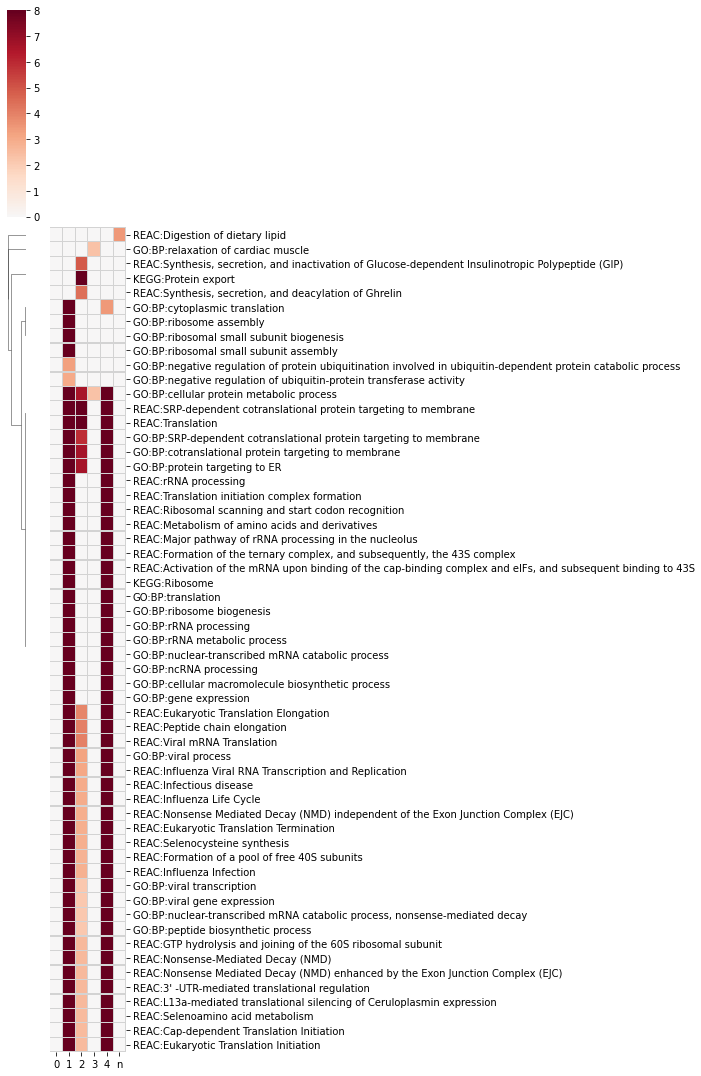

In [103]:
df_plot = pd.DataFrame()
dic_source = {'KEGG_2019_Mouse':'KEGG', 'GO_Biological_Process_2018':'GO:BP', 'Reactome_2016':'REAC'}
for group in group_list:
    temp_df = dic_pathway[group][['Adjusted P-value']]
    temp_df.index = ['%s:%s'%(dic_source[x],y.split(' (GO')[0].split(' Homo')[0]) 
                     for x,y in zip(dic_pathway[group]['Gene_set'], dic_pathway[group]['Term'])]
    temp_df.columns = [group]
    df_plot = df_plot.join(temp_df, how='outer')

df_plot.fillna(1, inplace=True)
df_plot = -np.log10(df_plot)
df_plot = df_plot.clip(upper=8)
# df_plot = df_plot.loc[df_plot.max(axis=1)>3]
df_plot = df_plot[group_list]
df_plot.index.name = ''
df_plot.columns = [x[0] for x in df_plot.columns]

sns.clustermap(df_plot, metric='cosine', col_cluster=False, 
               figsize=(10,15), cbar_pos=(0, 0.9, 0.05, 0.05),
               cmap='RdBu_r', center=0, linewidths=0.2, linecolor='lightgrey')

# sns.clustermap(df_plot, metric='euclidean', col_cluster=False, 
#                figsize=(10,10), cbar_pos=(0, 0.9, 0.05, 0.05),
#                cmap='RdBu_r', center=0, linewidths=0.2, linecolor='lightgrey')
plt.tight_layout()
# plt.savefig(FIG_PATH+'/IBD_pathway.svg')
plt.show()

In [99]:
# Compute genes driving each cluster 
df_gs_gwas = pd.read_csv(GS_FILE, sep='\t', index_col=0)
df_hom = pd.read_csv(DATA_PATH + '/gene_annotation/mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
gwas_gene_list = [dic_map[x] for x in df_gs_gwas.loc[trait, 'GENESET'].split(',') if x in dic_map]
df_contrib = md.compute_gene_contrib(adata, gwas_gene_list)

df_contrib_stats = pd.DataFrame(index=df_contrib.columns, columns=group_list, data=0)
for group in group_list:
    cell_list = list(adata.obs_names[adata.obs['leiden_sig']==group])
    temp_df_sig = df_contrib.loc[cell_list].copy()
    temp_df_rest = df_contrib.loc[~df_contrib.index.isin(cell_list)]
    df_contrib_stats[group] = [sp.stats.ttest_ind(temp_df_sig[x].values, temp_df_rest[x].values)[0]
                               for x in df_contrib.columns]

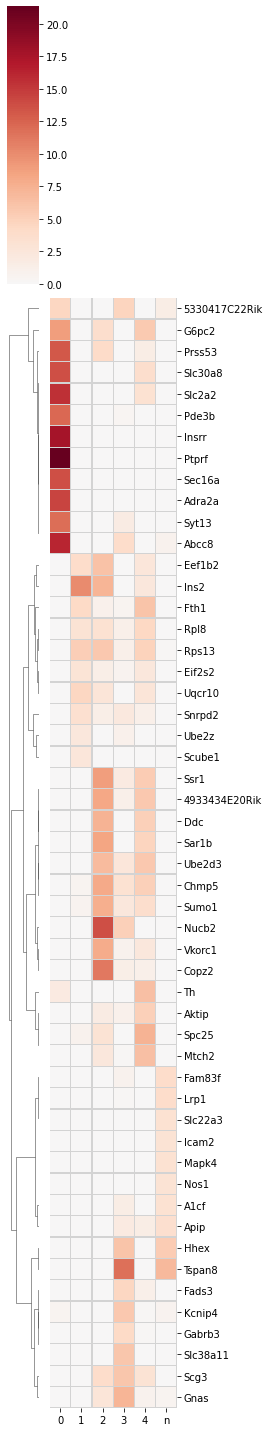

In [105]:
gene_list = []
for group in df_contrib_stats.columns:
    gene_list.extend(df_contrib_stats.sort_values(by=group, ascending=False).index[:10])
gene_list = list(set(gene_list))
df_plot = df_contrib_stats.loc[gene_list]
df_plot.values[df_plot.values<0] = 0
df_plot = df_plot[group_list]
df_plot.columns = [x[0] for x in df_plot.columns]

sns.clustermap(df_plot, metric='cosine', col_cluster=False, figsize=(4,20), 
               cbar_pos=(0, 0.8, 0.05, 0.05), cmap='RdBu_r', center=0, linewidths=0.2, linecolor='lightgrey')
plt.tight_layout()
# plt.savefig(FIG_PATH+'/IBD_trs_contrib_gene.svg')
plt.show()

### Correlation with BMI

In [58]:
# Curate covariates 
dic_cov = {}
dic_cov['facs'] = dic_data_proc['facs'].obs.copy()
dic_cov['facs']['age_num'] = [int(x.replace('m','')) for x in dic_cov['facs']['age']]
dic_cov['facs'] = dic_cov['facs'][['age_num', 'mt_prop']].copy()

dic_cov['xin'] = dic_data_proc['xin'].obs.copy()
dic_cov['xin']['Height_num'] = [int(x[0])+int(x[2])/12 for x in dic_cov['xin']['HbA1c']]
dic_cov['xin']['HbA1c_num'] = [float(x.split('%')[0])/100 for x in dic_cov['xin']['HbA1c']]
dic_cov['xin'] = dic_cov['xin'][['viability', 'Age', 'BMI', 'Height_num', 'Weight (lbs)', 'HbA1c_num']].copy()

In [59]:
# Compute p-value
df_stats = pd.DataFrame(columns=['COV', 'TRAIT', 'CORR', 'P'])
score='xin'
ds=score.split('.')[0]

for cov in dic_cov[ds].columns:
    for trait in DIC_TRAIT_LIST[ds]:
        df_plot = dic_cov[ds][[cov]].copy()
        df_plot = df_plot.join(dic_score[score][['%s.norm_score'%trait]])
        df_plot = df_plot.join(dic_ctrl_score[score][trait])
        corr_ = sp.stats.pearsonr(df_plot[cov].values, df_plot['%s.norm_score'%trait].values)[0]
#             corr_ = sp.stats.spearmanr(df_plot[cov].values, df_plot['%s.norm_score'%trait].values)[0]
        v_corr_ = np.zeros(500)
        for i in range(500):
            v_corr_[i] = sp.stats.pearsonr(df_plot[cov].values, df_plot['ctrl_norm_score_%d'%i].values)[0]
#                 v_corr_[i] = sp.stats.spearmanr(df_plot[cov].values, df_plot['ctrl_norm_score_%d'%i].values)[0]
        p_ = ((corr_ <= v_corr_).sum()+1) / 501
        df_stats.loc['%s.%s'%(cov,trait)] = [cov, trait, corr_, p_]
            
def p_2_str(p_):
    if p_>0.05:
        return 'n.s.'
    elif p_>0.01:
        return '*'
    elif p_>0.005:
        return '**'
    else: 
        return '***'
    
def p_2_str_num(p_):
    if p_>1/500.5:
        return 'P=%0.3f'%p_
    else:
        return 'P<0.002'
    
df_stats['P_STR'] = [p_2_str(x) for x in df_stats['P']]
df_stats['P_STR_NUM'] = [p_2_str_num(x) for x in df_stats['P']]

In [60]:
df_stats

,COV,TRAIT,CORR,P,P_STR,P_STR_NUM
viability.PASS_FastingGlucose_Manning,viability,PASS_FastingGlucose_Manning,-0.009141,0.572854,n.s.,P=0.573
viability.UKB_460K.biochemistry_Glucose,viability,UKB_460K.biochemistry_Glucose,0.092352,0.021956,*,P=0.022
viability.UKB_460K.biochemistry_HbA1c,viability,UKB_460K.biochemistry_HbA1c,0.109644,0.005988,**,P=0.006
viability.PASS_Type_2_Diabetes,viability,PASS_Type_2_Diabetes,0.028253,0.231537,n.s.,P=0.232
viability.PASS_Intelligence_SavageJansen2018,viability,PASS_Intelligence_SavageJansen2018,0.157123,0.001996,***,P<0.002
viability.PASS_VerbalNumericReasoning_Davies2018,viability,PASS_VerbalNumericReasoning_Davies2018,0.124755,0.003992,***,P=0.004
viability.UKB_460K.body_BMIz,viability,UKB_460K.body_BMIz,0.106780,0.011976,*,P=0.012
viability.UKB_460K.impedance_BASAL_METABOLIC_RATEz,viability,UKB_460K.impedance_BASAL_METABOLIC_RATEz,0.138093,0.001996,***,P<0.002
Age.PASS_FastingGlucose_Manning,Age,PASS_FastingGlucose_Manning,-0.011359,0.606786,n.s.,P=0.607
Age.UKB_460K.biochemistry_Glucose,Age,UKB_460K.biochemistry_Glucose,-0.061265,0.942116,n.s.,P=0.942


### Correlation with zonation 

In [17]:
# Get data and zonation profile 
dic_data_zon = {}

# FACS hep data 
ds = 'facs'
adata = dic_data_raw[ds][dic_cell_list[ds], :].copy()
temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obs = adata.obs.join(temp_adata.obs[[x for x in temp_adata.obs.columns if x not in adata.obs.columns]])
adata.obsm = temp_adata.obsm
adata = adata[adata.obs['leiden'].isin(['2', '4'])].copy()
adata.obs['zonation'] = adata.obsm['X_umap'][:,0]
adata.obs['ctrl'] = adata[:,'Alb'].X.toarray().flatten()
adata.obs['zonation_bin'] = pd.qcut(adata.obs['zonation'], 5, labels=False)
temp_dic = {0:-1, 1:-1, 2:0, 3:0, 4:1}
adata.obs['zonation_bin_o'] = [temp_dic[x] for x in adata.obs['zonation_bin']]
dic_data_zon['facs'] = adata.copy()

# # aizarani hep data
# ds = 'aizarani'
# temp_df = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/liver_atlas/'
#                       'Aizarani_Nature_2019_liver_supp_table3.txt', sep='\t', index_col=1)
# adata = dic_data_raw[ds][dic_cell_list[ds], :].copy()
# adata.obs['cluster_id'] = adata.obs['cluster_id'].astype('category')
# temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
# adata.obsm = temp_adata.obsm
# adata.obs['n_genes'] = (adata.X>0).sum(axis=1)
# # adata.obs = adata.obs.join(dic_score['aizarani'][['%s.fdr'%trait, '%s.norm_score'%trait]])
# adata.obs['zonation'] = -1
# # adata.obs['zonation_bin'] = pd.qcut(adata.obs['zonation'], 5, labels=False)
# temp_list = [x for x in temp_df.columns if x in adata.obs_names]
# adata.obs.loc[temp_list, 'zonation'] = np.arange(len(temp_list))
# adata = adata[adata.obs['zonation']>=0,:].copy()
# adata.obs['zonation_bin'] = pd.qcut(adata.obs['zonation'], 5, labels=False)
# adata.obs['ctrl'] = adata[:,'ALB'].X.toarray().flatten()
# adata = adata[adata.obs['n_genes']>=2000,:].copy()
# # adata = adata[adata.obs['%s.fdr'%trait]<0.1].copy()
# dic_data_zon['aizarani'] = adata.copy()

In [18]:
# Compute p-value
df_stats = pd.DataFrame(columns=['DPT', 'TRAIT', 'CORR', 'P'])


for dpt in ['zonation']:
    for ds in ['facs']:
        for trait in DIC_TRAIT_LIST['facs.hm']:
            df_plot = dic_data_zon[ds].obs[[dpt, 'ctrl']].copy()
            df_plot = df_plot.join(dic_score['facs.hm'].loc[dic_data_zon[ds].obs_names, ['%s.norm_score'%trait]])
            df_plot = df_plot.join(dic_ctrl_score['facs.hm'][trait])
            corr_ = sp.stats.pearsonr(df_plot[dpt].values, df_plot['%s.norm_score'%trait].values)[0]
#             corr_ = sp.stats.spearmanr(df_plot[dpt].values, df_plot['%s.norm_score'%trait].values)[0]
            v_corr_ = np.zeros(500)
            for i in range(500):
                v_corr_[i] = sp.stats.pearsonr(df_plot[dpt].values, df_plot['ctrl_norm_score_%d'%i].values)[0]
#                 v_corr_[i] = sp.stats.spearmanr(df_plot[dpt].values, df_plot['ctrl_norm_score_%d'%i].values)[0]
            p_ = ((corr_ <= v_corr_).sum()+1) / 501
            df_stats.loc['%s.%s'%(dpt,trait)] = [dpt, trait, corr_, p_]
            
def p_2_str(p_):
    if p_>0.05:
        return 'n.s.'
    elif p_>0.01:
        return '*'
    elif p_>0.005:
        return '**'
    else: 
        return '***'
    
def p_2_str_num(p_):
    if p_>1/500.5:
        return 'P=%0.3f'%p_
    else:
        return 'P<0.002'
    
df_stats['P_STR'] = [p_2_str(x) for x in df_stats['P']]
df_stats['P_STR_NUM'] = [p_2_str_num(x) for x in df_stats['P']]

KeyError: 'facs.hm'

In [16]:
df_stats

,DPT,TRAIT,CORR,P,P_STR,P_STR_NUM
zonation.Beta-oxidation,zonation,Beta-oxidation,0.219587,0.061876,n.s.,P=0.062
zonation.Cholesterol biosynthesis,zonation,Cholesterol biosynthesis,0.109686,0.121756,n.s.,P=0.122
zonation.Glycolysis,zonation,Glycolysis,-0.104894,0.846307,n.s.,P=0.846
zonation.Protein secretion,zonation,Protein secretion,0.137567,0.133733,n.s.,P=0.134
zonation.Bile acid production,zonation,Bile acid production,0.151109,0.135729,n.s.,P=0.136
zonation.Gluconeogenesis,zonation,Gluconeogenesis,-0.039517,0.602794,n.s.,P=0.603
zonation.Lipogenesis,zonation,Lipogenesis,0.090995,0.135729,n.s.,P=0.136
zonation.Xenobiotic metabolism,zonation,Xenobiotic metabolism,0.306812,0.005988,**,P=0.006


In [81]:
sp.stats.pearsonr(df_plot[dpt].values, df_plot['ctrl'].values)[0]

0.43842491823771557

In [91]:
from statsmodels.stats.multitest import multipletests

In [122]:
multipletests(v_p/5, method='fdr_bh')

(array([False,  True, False,  True,  True,  True, False,  True]),
 array([0.07904192, 0.04023952, 0.07436555, 0.04023952, 0.04023952,
        0.03832335, 0.05854957, 0.04023952]),
 0.006391150954545011,
 0.00625)

In [123]:
v_p/5

array([0.07904192, 0.01996008, 0.06506986, 0.01996008, 0.02195609,
       0.00479042, 0.04391218, 0.0251497 ])

In [117]:
v_p = np.array([min(x, 1-x) for x in df_stats['P']])

In [102]:
df_stats

,DPT,TRAIT,CORR,P,P_STR,P_STR_NUM
zonation_bin.Beta-oxidation,zonation_bin,Beta-oxidation,0.105355,0.395210,n.s.,P=0.395
zonation_bin.Cholesterol biosynthesis,zonation_bin,Cholesterol biosynthesis,-0.241579,0.900200,n.s.,P=0.900
zonation_bin.Glycolysis,zonation_bin,Glycolysis,0.095046,0.325349,n.s.,P=0.325
zonation_bin.Protein secretion,zonation_bin,Protein secretion,0.387076,0.099800,n.s.,P=0.100
zonation_bin.Bile acid production,zonation_bin,Bile acid production,-0.418860,0.890220,n.s.,P=0.890
zonation_bin.Gluconeogenesis,zonation_bin,Gluconeogenesis,0.516162,0.023952,*,P=0.024
zonation_bin.Lipogenesis,zonation_bin,Lipogenesis,0.167519,0.219561,n.s.,P=0.220
zonation_bin.Xenobiotic metabolism,zonation_bin,Xenobiotic metabolism,-0.450094,0.874251,n.s.,P=0.874


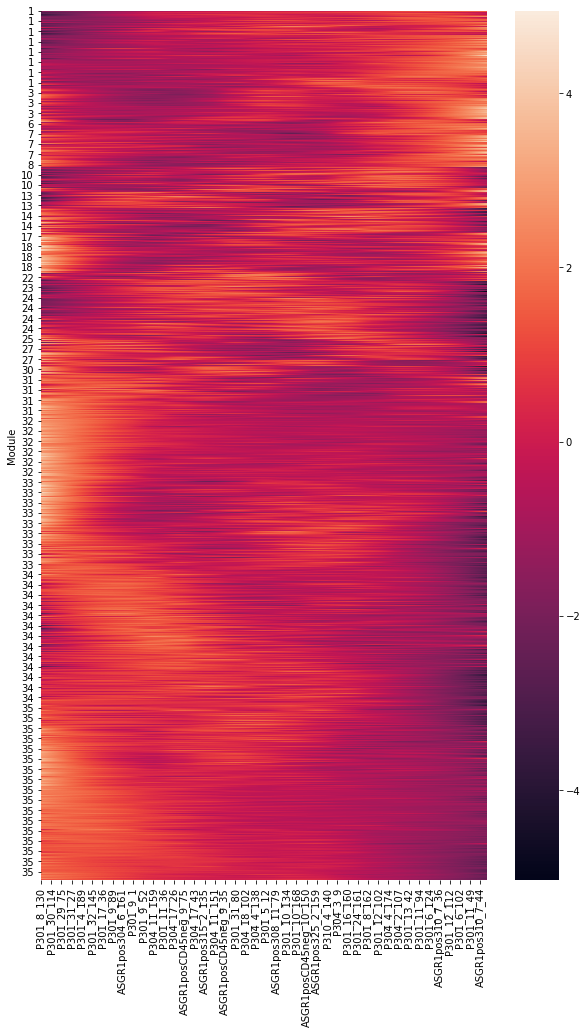

In [95]:
plt.figure(figsize=[10,16])
sns.heatmap(temp_df.iloc[:,1:])
plt.show()

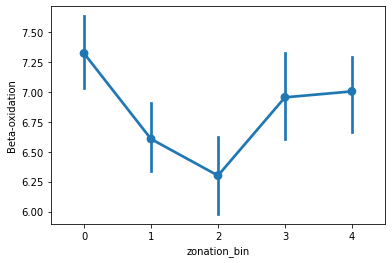

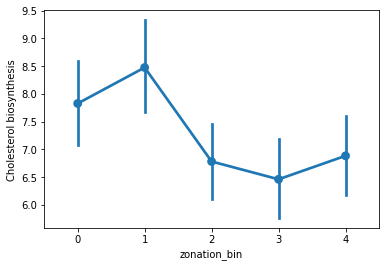

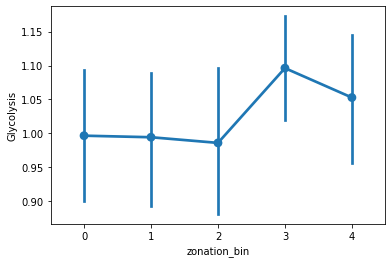

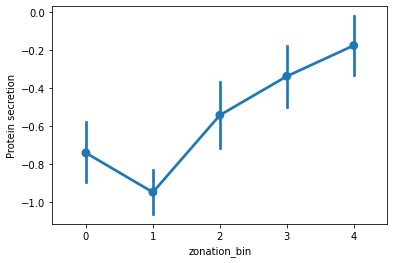

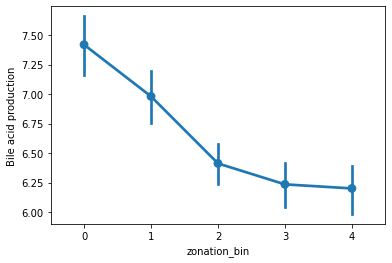

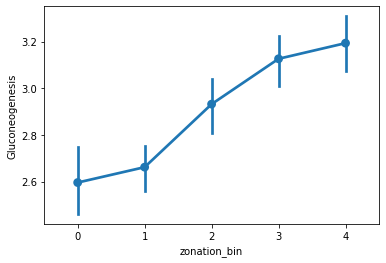

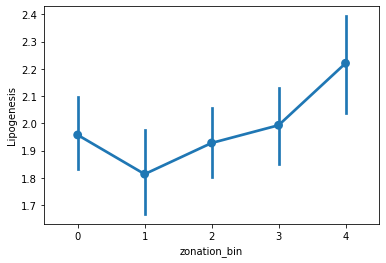

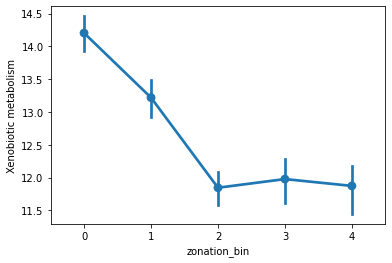

In [19]:
df = 'facs'
for trait in DIC_TRAIT_LIST['facs.hm']:
    
    df_plot = pd.DataFrame(data={'zonation': dic_data_zon[ds].obs['zonation'], 
                                 trait: dic_score['facs.hm'].loc[dic_data_zon[ds].obs_names, '%s.norm_score'%trait],
                                 'ctrl': dic_data_zon[ds].obs['ctrl']})
    df_plot['zonation_bin'] = pd.qcut(df_plot['zonation'], 5, labels=False)
    plt.figure()
    sns.pointplot(data=df_plot, x='zonation_bin', y=trait)
    plt.show()

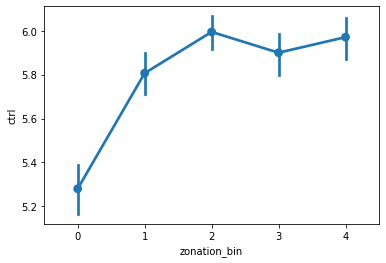

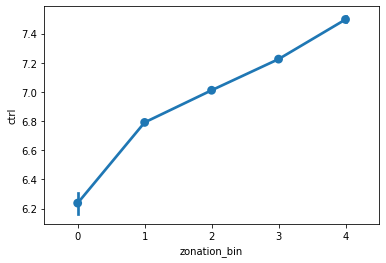

In [25]:
trait = 'UKB_460K.biochemistry_TotalBilirubin'
for ds in DS_LIST:
    
    df_plot = pd.DataFrame(data={'zonation': dic_data_zon[ds].obs['zonation'], 
                                 'score': dic_score[ds].loc[dic_data_zon[ds].obs_names, '%s.norm_score'%trait],
                                 'ctrl': dic_data_zon[ds].obs['ctrl']})
    df_plot['zonation_bin'] = pd.qcut(df_plot['zonation'], 5, labels=False)
    plt.figure()
    sns.pointplot(data=df_plot, x='zonation_bin', y='ctrl')
    plt.show()

In [ ]:
sc.pl.umap(dic_data_zon['facs'], color=['%s.norm_score'%trait, 'zonation', 'n_genes', 'cluster_id'])

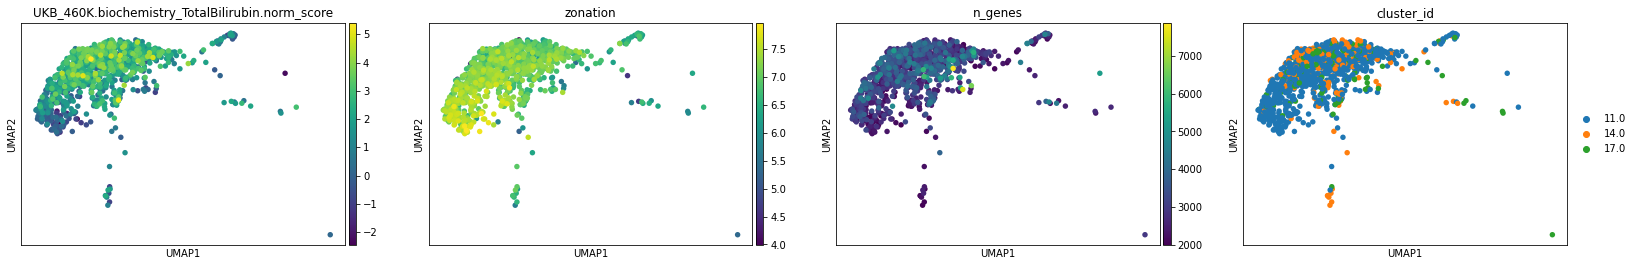

In [23]:
sc.pl.umap(dic_data_zon['aizarani'], color=['%s.norm_score'%trait, 'zonation', 'n_genes', 'cluster_id'])

In [122]:
dic_data_zon['aizarani'].obs['sig'] = dic_data_zon['aizarani'].obs['%s.fdr'%trait]<0.1
dic_data_zon['aizarani'].obs.groupby(['cluster_id', 'sig']).agg({'celltype':len})

celltype
cluster_id sig            
11.0       False       499
           True        228
14.0       False        85
           True         71
17.0       False        65
           True         55

In [117]:
temp_df

,GeneSymbol,P301_8_130,P301_8_127,P301_5_28,P301_4_98,P301_17_5,P301_10_123,P301_4_103,P301_8_131,P301_8_154,...,P301_6_175,P301_6_147,P301_18_146,P301_6_141,P301_6_153,P301_6_123,P301_6_181,P301_12_161,P301_6_178,P301_18_176
Module,,,,,,,,,,,,,,,,,,,,,
1,ACADM,-1.892985,-1.889814,-1.886645,-1.883479,-1.880315,-1.877153,-1.873993,-1.870836,-1.867681,...,-0.084579,-0.094507,-0.104455,-0.114421,-0.124406,-0.134410,-0.144433,-0.154474,-0.164533,-0.174611
1,AFM,-2.374369,-2.373595,-2.372819,-2.372039,-2.371257,-2.370472,-2.369684,-2.368893,-2.368099,...,0.565645,0.562683,0.559714,0.556738,0.553756,0.550767,0.547772,0.544771,0.541763,0.538749
1,AGL,-1.811760,-1.811965,-1.812166,-1.812363,-1.812555,-1.812744,-1.812929,-1.813109,-1.813285,...,2.140241,2.145407,2.150576,2.155749,2.160924,2.166102,2.171283,2.176467,2.181653,2.186842
1,ANTXR2,-1.799543,-1.797541,-1.795538,-1.793535,-1.791532,-1.789528,-1.787524,-1.785520,-1.783516,...,0.547106,0.546021,0.544938,0.543857,0.542777,0.541699,0.540624,0.539550,0.538479,0.537409
1,APLP2,-3.630012,-3.621315,-3.612630,-3.603959,-3.595299,-3.586652,-3.578018,-3.569395,-3.560785,...,0.962515,0.966911,0.971313,0.975720,0.980132,0.984550,0.988973,0.993401,0.997835,1.002273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,RPS19,1.950090,1.949356,1.948621,1.947886,1.947152,1.946417,1.945681,1.944946,1.944209,...,-2.185280,-2.188392,-2.191506,-2.194622,-2.197741,-2.200862,-2.203984,-2.207109,-2.210237,-2.213366
35,RPS9,1.899189,1.896911,1.894635,1.892362,1.890091,1.887822,1.885555,1.883291,1.881028,...,-2.033410,-2.034628,-2.035842,-2.037053,-2.038260,-2.039464,-2.040665,-2.041862,-2.043056,-2.044246
35,SEC14L2,2.087039,2.084403,2.081768,2.079134,2.076500,2.073868,2.071236,2.068605,2.065975,...,-1.725249,-1.725800,-1.726347,-1.726892,-1.727434,-1.727972,-1.728507,-1.729040,-1.729569,-1.730095


In [56]:
trait = 'UKB_460K.biochemistry_LDLdirect'

In [46]:
dic_data_zon['aizarani'].obs.loc['P301_8_130']

cluster_id             14
cell_id        P301_8_130
celltype      hepatocytes
n_counts          11997.8
zonation                0
Name: P301_8_130, dtype: object

In [35]:
set(temp_df.columns) - set(adata.obs_names)

{'GeneSymbol'}

In [36]:
temp_df.shape

(3395, 2535)

In [32]:
[x for x in temp_df.columns if x[0]!='P']

['GeneSymbol',
 'ASGR1pos310_6_158',
 'ASGR1pos310_6_146',
 'ASGR1pos310_5_21',
 'ASGR1pos310_5_15',
 'ASGR1pos315_1_39',
 'ASGR1pos310_8_135',
 'ASGR1pos308_11_57',
 'ASGR1pos310_5_36',
 'ASGR1pos325_1_21',
 'ASGR1pos310_5_85',
 'ASGR1pos325_1_66',
 'LSEC325_14_168',
 'ASGR1pos310_6_149',
 'ASGR1pos308_9_93',
 'ASGR1pos304_7_32',
 'ASGR1pos308_10_130',
 'Mixed315_11_57',
 'ASGR1pos308_10_169',
 'ASGR1pos304_7_93',
 'ASGR1pos304_7_24',
 'ASGR1pos308_10_122',
 'ASGR1pos308_9_41',
 'ASGR1pos304_7_30',
 'ASGR1pos325_1_43',
 'ASGR1pos315_3_48',
 'ASGR1pos304_8_146',
 'ASGR1pos304_5_11',
 'ASGR1pos304_7_53',
 'ASGR1pos304_8_103',
 'ASGR1pos304_5_7',
 'Mixed315_12_155',
 'ASGR1pos310_5_20',
 'ASGR1pos304_6_106',
 'ASGR1pos304_5_56',
 'ASGR1pos308_9_81',
 'ASGR1pos315_2_129',
 'ASGR1pos304_6_143',
 'ASGR1pos304_8_127',
 'ASGR1pos304_7_78',
 'ASGR1pos304_6_127',
 'ASGR1pos315_3_92',
 'ASGR1pos308_10_146',
 'ASGR1pos308_12_142',
 'ASGR1pos304_8_129',
 'ASGR1pos315_3_6',
 'ASGR1posCD45neg_9_68',

In [ ]:
df_plot = pd.DataFrame(data={'zonation':adata_sub.obsm['X_umap'][:,0].flatten(), 
                             'score': adata_sub.obs['%s.norm_score'%trait]})
df_plot['zonation_bin'] = pd.qcut(df_plot['zonation'], 5, labels=False)
sns.pointplot(data=df_plot, x='zonation_bin', y='score')
# plt.scatter(adata_sub.obsm['X_umap'][:,0].flatten(), adata_sub.obs['%s.norm_score'%trait])

### Prioritize gene sets 

In [52]:
df_gs_gwas = pd.read_csv(GS_FILE, sep='\t', index_col=0)
df_hom = pd.read_csv(DATA_PATH + '/gene_annotation/mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
background_set = set(dic_data_raw['facs'].var_names) & set(dic_map.values())

In [54]:
# Hep specific genes 
temp_adata = dic_data_raw['facs'][:, list(background_set)].copy()
temp_adata.obs['hep'] = 'nh'
temp_adata.obs.loc[dic_data_proc['facs'].obs_names, 'hep'] = 'h'
sc.tl.rank_genes_groups(temp_adata, groupby='hep', groups=['h'])
df_h = sc.get.rank_genes_groups_df(temp_adata, 'h')

... storing 'tissue_celltype' as categorical
... storing 'hep' as categorical


In [87]:
# GWAS and scTRS gene sets 
dic_gs = {}

for trait in DIC_TRAIT_LIST['facs']:
    
    # GWAS gene set
    dic_gs['%s.gwas'%trait] = set([dic_map[x] for x in df_gs_gwas.loc[trait, 'GENESET'].split(',') if x in dic_map])
    dic_gs['%s.gwas'%trait] = dic_gs['%s.gwas'%trait] & background_set
    
    # scTRS gene set
#     temp_list = dic_data_proc['facs'].obs_names[dic_data_proc['facs'].obs['leiden'].isin(['2'])]
#     temp_adata = dic_data_raw['facs'][temp_list, list(background_set)].copy()
    temp_adata = dic_data_raw['facs'][dic_data_proc['facs'].obs_names, list(background_set)].copy()
    temp_adata.obs['sctrs'] = dic_score['facs'].loc[temp_adata.obs_names, '%s.norm_score'%trait]
    md.correlate_gene(temp_adata, trs_name='sctrs', corr_opt='pearson', cov_list=None)
    df_gene_corr = pd.DataFrame(index=temp_adata.var_names)
    df_gene_corr[trait] = temp_adata.var[['trs_corr']].copy()
    df_gene_corr.sort_values(by=trait, ascending=False, inplace=True)
    dic_gs['%s.sctrs'%trait] = set(df_gene_corr.index[:len(dic_gs['%s.gwas'%trait])])
    
    # tcell-specific genes 
    dic_gs['%s.hep'%trait] = set(df_h['names'][:len(dic_gs['%s.gwas'%trait])])

In [88]:
# Gold standard gene sets 
dic_ref = {'UKB_460K.biochemistry_TotalBilirubin': 'Forgetta_biorxiv_2020:dbilirubin.med',
           'UKB_460K.biochemistry_LDLdirect': 'Forgetta_biorxiv_2020:ldl.med;Forgetta_biorxiv_2020:ldl.drug',
           'UKB_460K.biochemistry_Triglycerides': 'Forgetta_biorxiv_2020:tg.med;Forgetta_biorxiv_2020:tg.drug',
           'UKB_460K.biochemistry_Cholesterol': 'Freund_AJHG_2018:Cardiovascular_Disease',
           'UKB_460K.biochemistry_HDLcholesterol': 'Freund_AJHG_2018:Cardiovascular_Disease'}
for trait in dic_ref: 
     dic_gs['%s.ref'%trait] = set()
        
for gs_ref in ['Freund_AJHG_2018', 'Forgetta_biorxiv_2020']:
    df_gs_gold = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gold_standard_gs/%s.gs'%gs_ref,
                         sep='\t', index_col=0)
#     break
    for trait in dic_ref:
        for trait_ref in dic_ref[trait].split(';'):
            if gs_ref in trait_ref:
                trait_ref = trait_ref.replace('%s:'%gs_ref,'')
                dic_gs['%s.ref'%trait] = dic_gs['%s.ref'%trait] | \
                    set([dic_map[x] for x in df_gs_gold.loc[trait_ref, 'GENESET'].split(',') if x in dic_map])

In [89]:
# Compute stats 
dic_stats = {}
for res in ['gwas', 'sctrs', 'hep']:
    dic_stats[res] = pd.DataFrame(columns=['GWAS', 'GS', 'overlap', 'odds_ratio', 'odds_ratio.ub',
                                           'odds_ratio.lb', 'pval', 'overlap_gene'], dtype=float)
    for trait in dic_ref:
        gs_set = dic_gs['%s.%s'%(trait, res)] & background_set
        ge_set_ref = dic_gs['%s.ref'%trait] & background_set
        pvalue,oddsratio,or_ub,or_lb = util.test_overlap(gs_set, ge_set_ref, background_set)

        dic_stats[res].loc[trait,'GWAS'] = len(gs_set)
        dic_stats[res].loc[trait,'GS'] = len(ge_set_ref)
        dic_stats[res].loc[trait,'overlap'] = len(gs_set & ge_set_ref)
        dic_stats[res].loc[trait,'odds_ratio'] = oddsratio
        dic_stats[res].loc[trait,'odds_ratio.ub'] = or_ub
        dic_stats[res].loc[trait,'odds_ratio.lb'] = or_lb
        dic_stats[res].loc[trait,'pval'] = pvalue
        dic_stats[res].loc[trait,'overlap_gene'] = ','.join(sorted(gs_set & ge_set_ref))

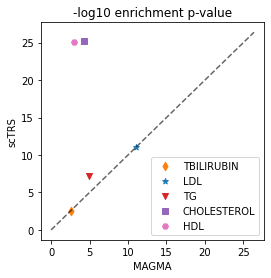

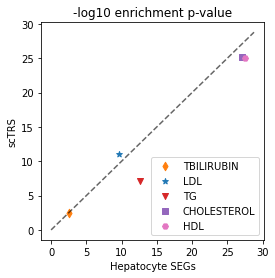

In [92]:
# Scatter plot for comparison 
dic_config = {'gwas': ['C0', 'MAGMA'], 
              'sctrs': ['C1', 'scTRS'], 
              'hep': ['C2', 'Hepatocyte SEGs']}

dic_config_trait = {'UKB_460K.biochemistry_TotalBilirubin': ['C1', 'd'], 
                    'UKB_460K.biochemistry_LDLdirect': ['C0', '*'], 
                    'UKB_460K.biochemistry_Triglycerides': ['C3', 'v'], 
                    'UKB_460K.biochemistry_Cholesterol': ['C4', 's'],
                    'UKB_460K.biochemistry_HDLcholesterol': ['C6', 'H'],
#                     'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED': ['C2', 'D']                   
                    }

df_plot = dic_stats[res][['GS']].copy()
for res in dic_config:
    df_plot['%s.nlog10pval'%res] = -np.log10(dic_stats[res].loc[df_plot.index, 'pval'].values)
df_plot = df_plot.astype(dtype=float)
df_plot['loc'] = range(df_plot.shape[0])

for res_ref in ['gwas', 'hep']:
    plt.figure(figsize=[4,4])
    ind_select = (~df_plot.index.isin(dic_config_trait.keys()))
    plt.scatter(df_plot.loc[ind_select, '%s.nlog10pval'%res_ref], df_plot.loc[ind_select, 'sctrs.nlog10pval'],
                color='k', alpha=0.2)
    for trait in dic_config_trait:
        plt.scatter(df_plot.loc[trait, '%s.nlog10pval'%res_ref], df_plot.loc[trait, 'sctrs.nlog10pval'], 
                    color=dic_config_trait[trait][0], marker=dic_config_trait[trait][1], 
                    label=DF_TRAIT_INFO.loc[trait, 'Code'])
    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()
    max_ = max(xmax, ymax)
    plt.plot([0, max_], [0, max_], '--', color='k', alpha=0.6)
    plt.xlabel(dic_config[res_ref][1])
    plt.ylabel(dic_config['sctrs'][1])
    plt.title('-log10 enrichment p-value')
    plt.legend(loc='lower right')
#     plt.tight_layout()
#     plt.savefig(FIG_PATH+'/comparison_gs_%s.svg'%res_ref)
    plt.show()

### Old code

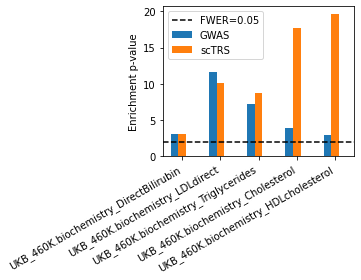

In [109]:
dic_config = {'gwas': ['C0', 'GWAS'], 
              'sctrs': ['C1', 'scTRS']}

df_plot = dic_stats[res][['GS']].copy()
for res in ['gwas', 'sctrs']:
    df_plot['%s.nlog10pval'%res] = -np.log10(dic_stats[res].loc[df_plot.index, 'pval'].values)
#     df_plot['%s.or'%res] = dic_stats[res].loc[df_plot.index, 'odds_ratio']
#     df_plot['%s.or_lb'%res] = dic_stats[res].loc[df_plot.index, 'odds_ratio.lb']
#     df_plot['%s.or_ub'%res] = dic_stats[res].loc[df_plot.index, 'odds_ratio.ub']
df_plot = df_plot.astype(dtype=float)
df_plot['loc'] = range(df_plot.shape[0])


plt.figure(figsize=[5, 4])
for i_res,res in enumerate(['gwas', 'sctrs']):
    mat_xerr = np
    plt.bar(df_plot['loc']+0.2*i_res-0.2, df_plot['%s.nlog10pval'%res],
            width=0.2, color=dic_config[res][0], label=dic_config[res][1])

fwer_thres = -np.log10(0.05/df_plot.shape[0])
plt.plot([-0.5, df_plot.shape[0]-0.5], [fwer_thres, fwer_thres], color='k', linestyle='--', 
         label='FWER=0.05')

plt.legend()
plt.xticks(df_plot['loc'], [x for x in df_plot.index], rotation=30, ha='right')
plt.ylabel('Enrichment p-value')
plt.xlim([-0.5, df_plot.shape[0]-0.5])
plt.tight_layout()
plt.savefig(FIG_PATH+'/comparison_gs.svg')
plt.show()